# SHAP Aggregation Insights

* Show signed feature importance, comparing with SHAP summary plot
* Aggregated all forece plots results together, show signed feature contribution to the forecasting values
* SHAP version is `shap==0.41.0`

In [1]:
import pandas as pd
import timeit
import lightgbm as lgb
from lightgbm import LGBMRegressor
import optuna
import shap
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Get a Trained Model

In [147]:
df = pd.read_pickle('sales.pkl')

y = df['Sales']
X = df.drop(['Sales', 'Date', 'PromoInterval', 'StateHoliday'], axis=1)

print(X.shape, y.shape)
X.head()

(693861, 17) (693861,)


,Store,Year,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Customers,Open,Promo,SchoolHoliday
0,1,2015,7,3,2,0,1270.0,9,2008,0,-1,-1,5,555,1,1,1
1,1,2015,7,3,2,0,1270.0,9,2008,0,-1,-1,4,546,1,1,1
2,1,2015,7,3,2,0,1270.0,9,2008,0,-1,-1,3,523,1,1,1
3,1,2015,7,3,2,0,1270.0,9,2008,0,-1,-1,2,560,1,1,1
4,1,2015,7,3,2,0,1270.0,9,2008,0,-1,-1,1,612,1,1,1


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

params = {
    'num_leaves': 10786,
    'learning_rate': 0.23324362552743075,
    'subsample': 0.5960525260632918,
    'max_bin': 9,
    'colsample_bytree': 0.9792283949360767,
    'reg_alpha': 0.11863728553565003,
    'reg_lambda': 6.4741850755867505,
    'max_depth': 7,
}

model = LGBMRegressor(objective='regression', metric='mape',
                       random_state=10, **params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f'Testing R2 is {r2}')

(485702, 17) (485702,) (208159, 17) (208159,)
Testing R2 is 0.9738677274749695


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

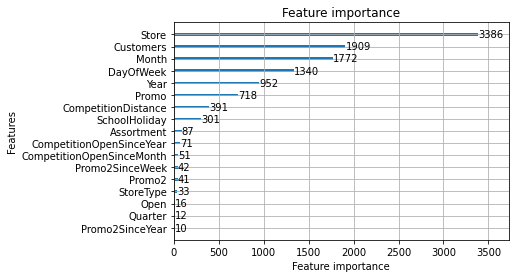

In [18]:
lgb.plot_importance(model)

## SHAP Built-in Insights

In [206]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
base_value = explainer.expected_value
if isinstance(base_value, list):
    base_value = base_value[1]
print(f"Explainer expected value (Base Value): {base_value}")

Explainer expected value (Base Value): 5780.179374439874


In [207]:
shap_df = pd.DataFrame(shap_values)
shap_df.columns = X_test.columns
shap_df['SHAP_SUM'] = shap_df.sum(axis=1) + base_value
shap_df['FORECAST'] = y_pred
shap_df['BASE_VALUE'] = base_value

print(min(y_test), min(shap_df['FORECAST']), min(shap_df['SHAP_SUM']))  # there are negative forecasted values
print(f"{round(shap_df[shap_df['FORECAST'] < 0].shape[0]*100/shap_df.shape[0], 2)}%")  # % of negative predicted values

shap_df.head()

0 -712.32188029265 -712.3218802926476
8.79%


,Store,Year,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Customers,Open,Promo,SchoolHoliday,SHAP_SUM,FORECAST,BASE_VALUE
0,-316.482815,-35.373272,12.461016,0.154059,-322.068268,-0.200356,-38.775307,1.211528,-4.674581,-0.322909,-28.631125,-0.582660,-166.706095,470.613466,-1.546093,433.029826,50.348514,5832.634301,5832.634301,5780.179374
1,20.299440,14.964603,-47.822935,-0.030042,-248.179646,0.767133,27.630008,-0.089592,-1.885714,-1.900797,-23.449598,-0.463888,1.234664,-2005.264461,0.741043,-295.885941,-17.100218,3203.743435,3203.743435,5780.179374
2,-1563.183096,-3.665490,692.475515,0.015196,-376.694325,-2.931224,-77.971746,4.147151,19.687868,-0.331496,-55.202282,-2.426211,394.222975,1648.790888,-3.800972,602.560381,-26.707847,7029.164660,7029.164660,5780.179374
3,-483.317482,-89.515561,33.487918,0.011640,-166.420924,-0.190771,-111.197137,-0.522845,-29.806265,0.160064,25.231167,0.688112,92.413551,3185.639612,0.262211,-592.969576,-19.018390,7625.114698,7625.114698,5780.179374
4,348.747083,13.432387,-114.085335,-0.020403,487.191465,0.575950,1.837176,0.260703,-3.452030,-0.798750,-12.597873,-0.427737,19.745126,-935.226803,0.539368,-466.460806,-13.322255,5106.116640,5106.116640,5780.179374


In [21]:
exp = shap.Explanation(shap_values, 
                  base_value, 
                  data=X_test.values, 
                  feature_names=X_test.columns)
print(exp.shape)
exp

(208159, 17)


.values =
array([[-3.16482815e+02, -3.53732718e+01,  1.24610157e+01, ...,
        -1.54609317e+00,  4.33029826e+02,  5.03485144e+01],
       [ 2.02994401e+01,  1.49646031e+01, -4.78229351e+01, ...,
         7.41043359e-01, -2.95885941e+02, -1.71002183e+01],
       [-1.56318310e+03, -3.66549033e+00,  6.92475515e+02, ...,
        -3.80097198e+00,  6.02560381e+02, -2.67078467e+01],
       ...,
       [-1.26020335e+02, -1.24153957e+01, -6.93898376e+00, ...,
         1.23581492e+01, -2.31841951e+02, -1.96365701e+01],
       [-2.65876968e+02,  3.29714826e+01, -4.18080095e+00, ...,
         3.82104499e+01, -3.21124515e+02, -1.45113241e+01],
       [ 2.18117901e+02,  7.56371993e+00, -8.51107329e+01, ...,
         5.61525144e-01, -3.64416516e+02, -8.28775043e+00]])

.base_values =
5780.179374439874

.data =
array([['6', 2014, 7, ..., 1, 1, 1],
       ['315', 2014, 4, ..., 1, 0, 0],
       ['569', 2014, 12, ..., 1, 1, 0],
       ...,
       ['223', 2014, 3, ..., 0, 0, 0],
       ['905', 2013, 6,

### Local Plots

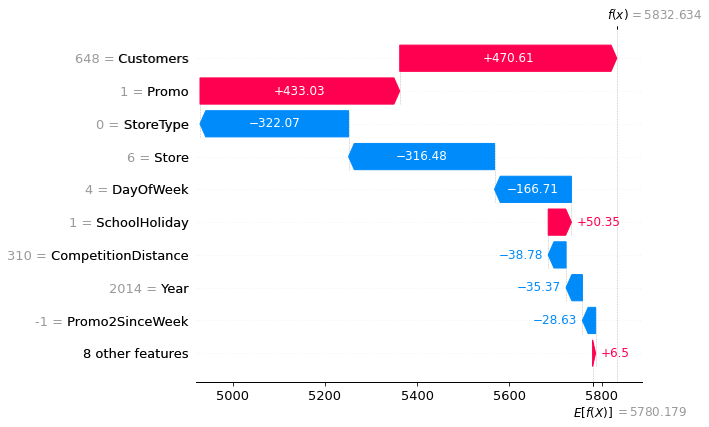

In [22]:
idx=0
shap.plots.waterfall(exp[idx])

In [149]:
shap.initjs()
shap.plots.force(exp[idx])

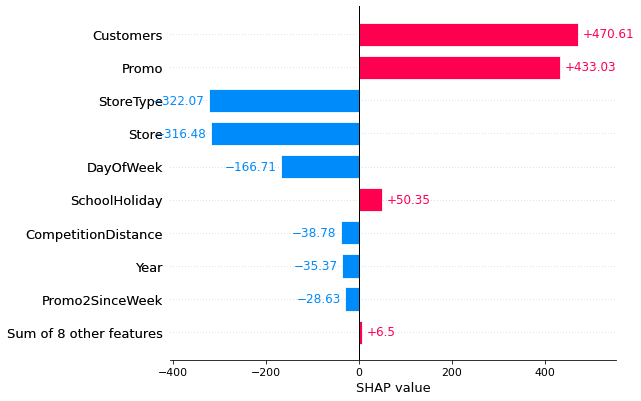

In [24]:
shap.plots.bar(exp[0])

### Global Plots

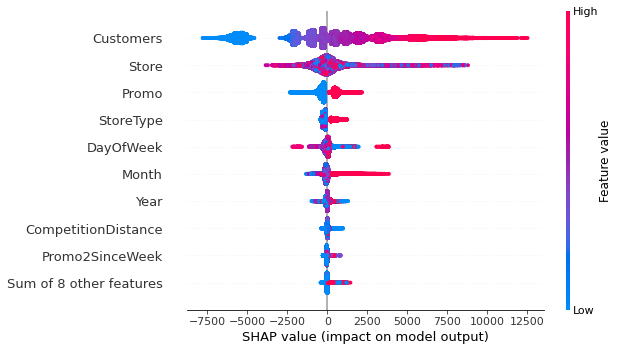

In [25]:
shap.plots.beeswarm(exp)

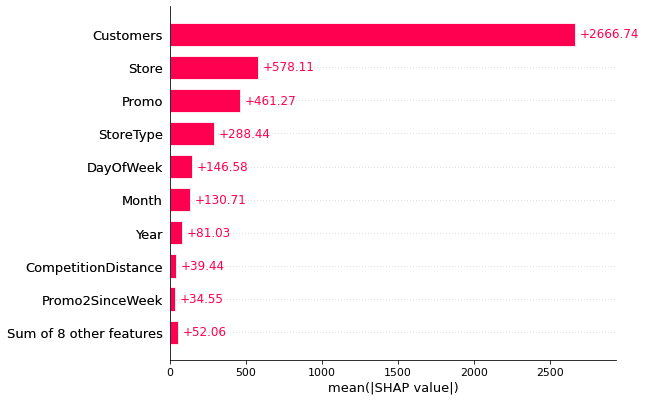

In [34]:
shap.plots.bar(exp)

#### NOTE
* SHAP feature clustering measures feature redundancy through model loss comparisions.

18it [1:45:04, 370.83s/it]                                                                                                                                                                                                              


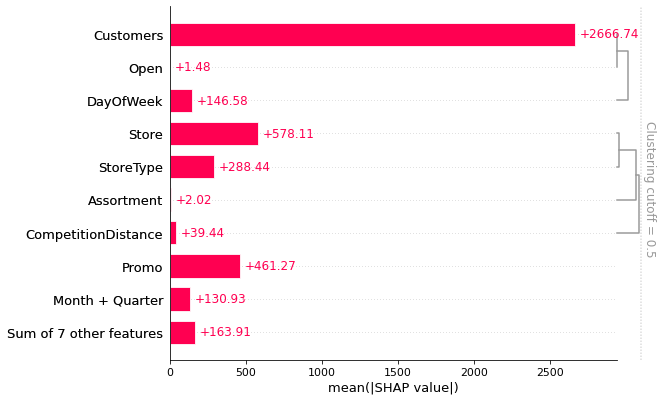

In [27]:
clustering = shap.utils.hclust(X_train, y_train)  # takes very long time to run
shap.plots.bar(exp, clustering=clustering)

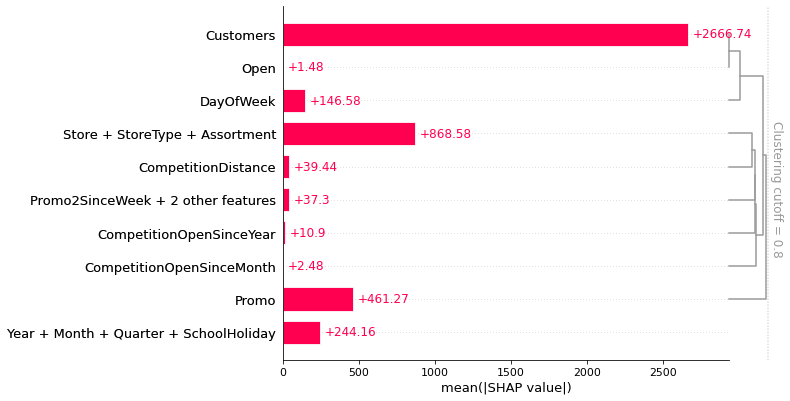

In [32]:
shap.plots.bar(exp, clustering=clustering, clustering_cutoff=0.8)

## DIY SHAP Insights


### Aggregated SHAP Value
* In SHAP built-in insights, global view often uses absolute SHAP and you can't tell overall contribution from a feature is positive or nagetive. `beeswarm` plot gives some idea but has no quantitive output. `shap.plots.bar` looks like has `Explaination.sum` order, but got complex error. Because of these reasons, I'm going to implement SHAP global insights based using SHAP original values instead of absolute ones.

In [43]:
shap_df.head()

,Store,Year,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Customers,Open,Promo,SchoolHoliday,SHAP_SUM,FORECAST,BASE_VALUE
0,-316.482815,-35.373272,12.461016,0.154059,-322.068268,-0.200356,-38.775307,1.211528,-4.674581,-0.322909,-28.631125,-0.582660,-166.706095,470.613466,-1.546093,433.029826,50.348514,5832.634301,5832.634301,5780.179374
1,20.299440,14.964603,-47.822935,-0.030042,-248.179646,0.767133,27.630008,-0.089592,-1.885714,-1.900797,-23.449598,-0.463888,1.234664,-2005.264461,0.741043,-295.885941,-17.100218,3203.743435,3203.743435,5780.179374
2,-1563.183096,-3.665490,692.475515,0.015196,-376.694325,-2.931224,-77.971746,4.147151,19.687868,-0.331496,-55.202282,-2.426211,394.222975,1648.790888,-3.800972,602.560381,-26.707847,7029.164660,7029.164660,5780.179374
3,-483.317482,-89.515561,33.487918,0.011640,-166.420924,-0.190771,-111.197137,-0.522845,-29.806265,0.160064,25.231167,0.688112,92.413551,3185.639612,0.262211,-592.969576,-19.018390,7625.114698,7625.114698,5780.179374
4,348.747083,13.432387,-114.085335,-0.020403,487.191465,0.575950,1.837176,0.260703,-3.452030,-0.798750,-12.597873,-0.427737,19.745126,-935.226803,0.539368,-466.460806,-13.322255,5106.116640,5106.116640,5780.179374


In [40]:
# double check to see whether there's different forecasted value and shap_sum
test_df = shap_df[round(shap_df['SHAP_SUM'], 6) != round(shap_df['FORECAST'], 6)]
print(test_df.shape)

(0, 19)


In [97]:
avg_sum_shap_df = pd.DataFrame(round(shap_df[X_test.columns].sum(axis=0)/shap_df.shape[0], 2)).rename(index=str, columns={0: 'AVG_SHAP'})
avg_sum_shap_df['ABS_AVG_SHAP'] = abs(avg_sum_shap_df['AVG_SHAP'])
avg_sum_shap_df = avg_sum_shap_df.sort_values(by='ABS_AVG_SHAP')
avg_sum_shap_df['ABS_AVG_SHAP_PERCT'] = round(avg_sum_shap_df['ABS_AVG_SHAP'] *100/sum(avg_sum_shap_df['ABS_AVG_SHAP']), 2)
avg_sum_shap_df['signed_ABS_AVG_SHAP_PERCT'] = round(avg_sum_shap_df['ABS_AVG_SHAP'] *100/sum(avg_sum_shap_df['ABS_AVG_SHAP']), 2) * np.sign(avg_sum_shap_df['AVG_SHAP'])
avg_sum_shap_df

,AVG_SHAP,ABS_AVG_SHAP,ABS_AVG_SHAP_PERCT,signed_ABS_AVG_SHAP_PERCT
Open,0.02,0.02,0.01,0.01
Quarter,-0.03,0.03,0.02,-0.02
Promo2,0.04,0.04,0.02,0.02
CompetitionOpenSinceMonth,0.12,0.12,0.07,0.07
Promo2SinceYear,-0.45,0.45,0.27,-0.27
Assortment,0.51,0.51,0.31,0.31
CompetitionOpenSinceYear,-0.74,0.74,0.45,-0.45
Year,0.87,0.87,0.52,0.52
SchoolHoliday,-1.84,1.84,1.11,-1.11
DayOfWeek,-2.78,2.78,1.67,-1.67


In [106]:
def show_agg_shap(x, y, show_perct=False):
    plt.figure(figsize=(15,7))

    clrs = ['dodgerblue' if (v<0) else 'deeppink' for v in y]
    bar = plt.barh(x, y, color=clrs)
    plt.bar_label(bar, fontsize=12)  # mark x value at the top of bar
    plt.yticks(rotation='15', fontsize=14, horizontalalignment="right")
    if show_perct:
        plt.xlabel('ABS AVG SHAP %')
        plt.title('Overall SHAP Contribution %')
    else:
        plt.xlabel('AVG SHAP')
        plt.title('Overall SHAP')
    
    plt.show()

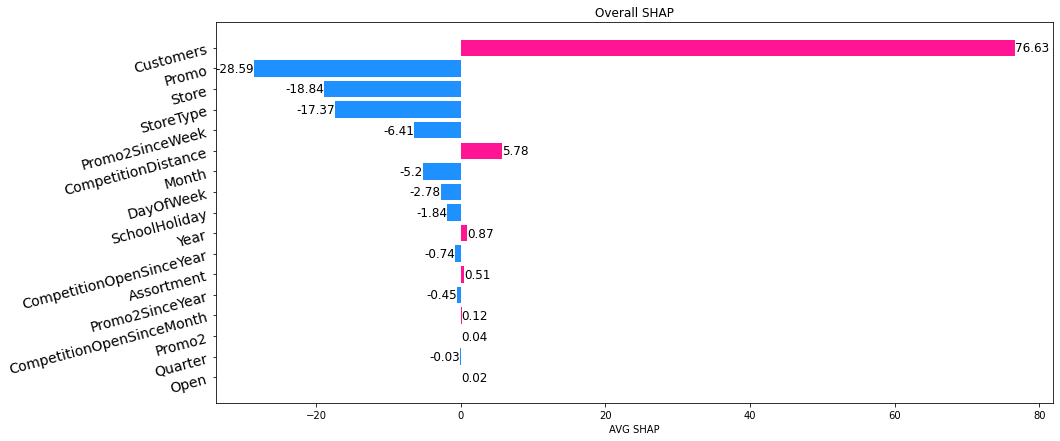

In [108]:
show_agg_shap(x=avg_sum_shap_df.index, y=avg_sum_shap_df['AVG_SHAP'])

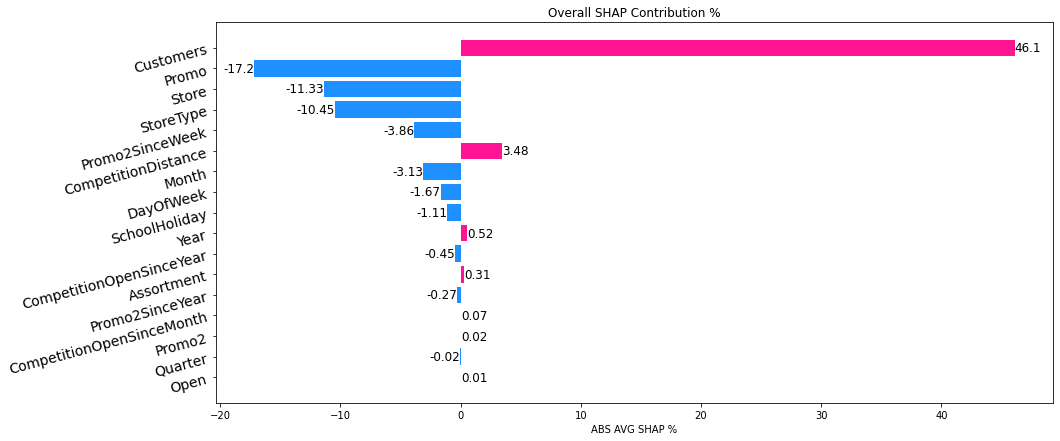

In [109]:
show_agg_shap(x=avg_sum_shap_df.index, y=avg_sum_shap_df['signed_ABS_AVG_SHAP_PERCT'], show_perct=True)

### Shifted SHAP Value

In [212]:
def local_shap_shift(r, feature_cols, min_forecast=0.00000001):
    if r['FORECAST'] >= min_forecast:
        return r
    
    total_shift = min_forecast - r['FORECAST']
    total_abs_shap = sum([abs(v) for col, v in r.items() if col in feature_cols])
    
    shifted_r = r.copy()
    for col in feature_cols:
        shifted_r[col] = r[col] + total_shift * abs(r[col]) / total_abs_shap
    shifted_r['SHAP_SUM'] = sum([v for col, v in shifted_r.items() if col in feature_cols]) + shifted_r['BASE_VALUE']
        
    return shifted_r


def shap_shift(shap_df, feature_cols, min_forecast=0):
    """
    Sometimes, we don't want to show any negative forecasted value 
    (negative values can be inevitable, 
    check here https://datascience.stackexchange.com/questions/565/why-does-gradient-boosting-regression-predict-negative-values-when-there-are-no).
    SHAP can help us achieve non-negative forecast display while trying to keep the original feature importance as much as possible.
    """
    shap_dict = shap_df.T.to_dict().values()

    shifted_shap_dct = {}
    idx = 0
    for r in shap_dict:
        shifted_r = local_shap_shift(r, feature_cols, min_forecast=0)
        shifted_shap_dct[idx] = shifted_r
        idx +=1
        
    shifted_shap_df = pd.DataFrame(shifted_shap_dct).T
    
    return shifted_shap_df

In [209]:
shifted_shap_values = shap_shift(shap_df, feature_cols=X_test.columns, min_forecast=0)
print(shifted_shap_values.shape)

shifted_shap_values.head()

{'Store': 775.2331247250373, 'Year': -70.25086504085142, 'Month': -190.103313087412, 'Quarter': 0.03871821139833655, 'StoreType': -110.08564274071341, 'Assortment': -22.821593925693413, 'CompetitionDistance': 40.5671463943389, 'CompetitionOpenSinceMonth': 4.979204299108375, 'CompetitionOpenSinceYear': 32.79874020947946, 'Promo2': 0.7455671939161064, 'Promo2SinceWeek': -24.627734928770984, 'Promo2SinceYear': -1.1234502646288613, 'DayOfWeek': -272.3777920193008, 'Customers': -6723.203277755157, 'Open': 17.35992364844997, 'Promo': 41.156271339701426, 'SchoolHoliday': 9.213719008575818, 'SHAP_SUM': -712.3218802926476, 'FORECAST': -712.32188029265, 'BASE_VALUE': 5780.179374439874}
{'Store': 841.4723367405129, 'Year': -64.24833264730594, 'Month': -173.86007829928593, 'Quarter': 0.04202645988756882, 'StoreType': -100.67945768902543, 'Assortment': -20.871619975455843, 'CompetitionDistance': 44.03337574545252, 'CompetitionOpenSinceMonth': 5.404648670250266, 'CompetitionOpenSinceYear': 35.601203

,Store,Year,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Customers,Open,Promo,SchoolHoliday,SHAP_SUM,FORECAST,BASE_VALUE
0,841.472337,-64.248333,-173.860078,0.042026,-100.679458,-20.871620,44.033376,5.404649,35.601204,0.809272,-22.523437,-1.027458,-249.104676,-6148.744224,18.843229,44.672838,10.000978,1.000171e-08,-712.321880,5780.179374
1,-269.658828,-1.023306,-44.621515,-0.026461,-108.508578,0.603753,-19.360599,3.193739,2.678389,0.142649,-15.933116,2.296868,87.220645,-5170.043929,-3.207372,-238.312895,-5.618819,9.999894e-09,-19.542487,5780.179374


In [140]:
shap_df[shap_df['FORECAST']<-500].head()

,Store,Year,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Customers,Open,Promo,SchoolHoliday,SHAP_SUM,FORECAST,BASE_VALUE
117988,269.364930,-56.423512,-148.965816,0.126327,-85.255934,-1.230602,-17.928916,5.898445,-15.766244,-0.531531,23.375581,2.082990,-223.491345,-4665.974288,7.572899,178.270133,14.302888,-532.802690,-532.802690,5780.179374
146906,1008.704776,-52.634930,-142.433471,0.050379,-82.480836,-17.098907,52.784476,6.478757,42.676512,0.970105,-18.452144,-0.841737,-204.077003,-5037.309259,22.588093,53.551024,11.988552,-712.321880,-712.321880,5780.179374
162232,-747.047209,-139.256910,-14.915508,-1.903834,-81.071672,18.209638,-11.237040,4.610104,-10.090170,-0.297046,-20.924524,-0.691499,-39.833778,-3912.479635,53.920037,297.142475,-10.840681,-581.736062,-581.736062,5780.179374


In [210]:
shap.initjs()
shap.plots.force(exp[146906])

In [228]:
shifted_shap_df = shap_shift(shap_df, feature_cols=X_test.columns, min_forecast=0)
print(shifted_shap_df.shape)

shifted_shap_df.head()

(208159, 20)


,Store,Year,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Customers,Open,Promo,SchoolHoliday,SHAP_SUM,FORECAST,BASE_VALUE
0,-316.482815,-35.373272,12.461016,0.154059,-322.068268,-0.200356,-38.775307,1.211528,-4.674581,-0.322909,-28.631125,-0.582660,-166.706095,470.613466,-1.546093,433.029826,50.348514,5832.634301,5832.634301,5780.179374
1,20.299440,14.964603,-47.822935,-0.030042,-248.179646,0.767133,27.630008,-0.089592,-1.885714,-1.900797,-23.449598,-0.463888,1.234664,-2005.264461,0.741043,-295.885941,-17.100218,3203.743435,3203.743435,5780.179374
2,-1563.183096,-3.665490,692.475515,0.015196,-376.694325,-2.931224,-77.971746,4.147151,19.687868,-0.331496,-55.202282,-2.426211,394.222975,1648.790888,-3.800972,602.560381,-26.707847,7029.164660,7029.164660,5780.179374
3,-483.317482,-89.515561,33.487918,0.011640,-166.420924,-0.190771,-111.197137,-0.522845,-29.806265,0.160064,25.231167,0.688112,92.413551,3185.639612,0.262211,-592.969576,-19.018390,7625.114698,7625.114698,5780.179374
4,348.747083,13.432387,-114.085335,-0.020403,487.191465,0.575950,1.837176,0.260703,-3.452030,-0.798750,-12.597873,-0.427737,19.745126,-935.226803,0.539368,-466.460806,-13.322255,5106.116640,5106.116640,5780.179374


In [229]:
shifted_exp = shap.Explanation(shifted_shap_df[X_test.columns].values, 
                  base_value, 
                  data=X_test.values, 
                  feature_names=X_test.columns)
print(shifted_exp.shape)

(208159, 17)


In [230]:
shap.plots.force(shifted_exp[146906])

In [232]:
print(f"{round(shifted_shap_df[round(shifted_shap_df['SHAP_SUM'], 3) < 0].shape[0]*100/shifted_shap_df.shape[0], 2)}%")
print(min(shifted_shap_df['SHAP_SUM']))  # almost 0

0.0%
-7.639755494892597e-11
